In [9]:
# draw ensemble analys
# id,arrival_time,start_service_times,start_service_times,completion_time
# time,event_id,event_type,timing,length_event_list,length_queue1,length_queue2,in_service1,in_service2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [54]:
# get list of file path based on Parameters:
#mean_interarrival,mean_machine_time_1,mean_machine_time_2,max_queue_1,max_queue_2,time_units,std_machine_1
from dataclasses import dataclass, field

@dataclass
class Parameter:
    mean_interarrival:float
    mean_machine_time_1:float
    mean_machine_time_2:float
    max_queue_1:int
    max_queue_2:int
    time_units:str
    std_machine_1:float

def get_parameter(s):
    s = s.split(',')
    
    return Parameter(
        mean_interarrival=float(s[0]),
        mean_machine_time_1=float(s[1]),
        mean_machine_time_2=float(s[2]),
        max_queue_1=int(s[3]),
        max_queue_2=int(s[4]),
        time_units=s[5],
        std_machine_1=float(s[6])
    )

# the file path should look like this: data/mean_interarrival_60.0/max_queue_1_9223372036854775807/max_queue_2_4/mean_machine_time_125.0
def get_file_path_from_parameters(p, n=1000):
    states_files, entities_files= [],[]
    root_path = f"data/mean_interarrival_{p.mean_interarrival}/max_queue_1_{p.max_queue_1}/max_queue_2_{p.max_queue_2}/mean_machine_time_1{p.mean_machine_time_1}/mean_machine_time_2{p.mean_machine_time_2}"
    for i in range(2,n+1):
        states_files.append(f"{root_path}/seed{i}/state.csv")
        entities_files.append(f"{root_path}/seed{i}/entities.csv")
    return states_files, entities_files

def get_ensemble_data(states_file_path, sample_steps=30):
    original_states = []
    ensemble_states = []

    for file_path in states_file_path:
        # Read the file
        df = pd.read_csv(file_path, skiprows=9)

        # Trim whitespace from all string columns
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        # Filter for 'before' timings and 'Arrival' events
        filtered_df = df[(df["timing"] == "before") & (df["event_type"] == "Arrival")]

        # Store the original filtered dataframe
        original_states.append(filtered_df)

        # Drop 'timing' and 'event_type' columns
        filtered_df = filtered_df.drop(columns=["timing", "event_type"])

        # Create a complete range of time bins
        max_time = filtered_df['time'].max()
        time_bins = np.arange(0, max_time + sample_steps, step=sample_steps)

        # Assign each row to a time bin
        filtered_df['time_bin'] = pd.cut(filtered_df['time'], bins=time_bins, right=False, labels=time_bins[:-1])


        # Group by time_bin and calculate the mean
        resampled_df = filtered_df.groupby('time_bin',observed=False).mean()
        resampled_df.reset_index(inplace=True)

        ensemble_states.append(resampled_df)

    return original_states, ensemble_states

def plot_ensemble_average(original_states, ensemble_states, column_name,guide_line=None):
    """
    Plots the first 10 specified columns from the original states and the ensemble average, 
    emphasizing the ensemble average and including a legend only for it.

    Parameters:
    - original_states: List of original DataFrames.
    - ensemble_states: List of ensemble DataFrames.
    - column_name: The name of the column to plot.
    """
    
    plt.figure(figsize=(12, 6))

    # Plotting the specified column from the first 10 original states with reduced opacity
    for i, df in enumerate(original_states[:10]):  # Limit to first 10 original states
        if column_name in df.columns:
            plt.plot(df['time'], df[column_name], alpha=0.3)  # Reduced opacity, no label

    # Concatenating and calculating the ensemble average
    all_ensemble_data = pd.concat([df.set_index('time_bin')[column_name] for df in ensemble_states], axis=1)
    ensemble_avg = all_ensemble_data.mean(axis=1, skipna=True)
    ensemble_avg.dropna(inplace=True)
    # drop last 10 rows
    # ensemble_avg = ensemble_avg[:-10]
    # Plotting the ensemble average with emphasis and a label for the legend
    # drop last 20 rows
    ensemble_avg = ensemble_avg.iloc[:-10]
    plt.plot(ensemble_avg.index, ensemble_avg, color='red', linewidth=3, label='Ensemble Average', alpha=1.0)
    # draw a line at 59
    if guide_line is not None:
        plt.axhline(y=guide_line, color='r', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(column_name)
    plt.title(f'Comparison of {column_name}: Original Data vs. Ensemble Average')
    plt.legend()
    plt.show()
    return ensemble_avg



def draw_graph(s,column_name, guide_line=None):
    p = get_parameter(s)
    states_files, entities_files = get_file_path_from_parameters(p)
    original_states, ensemble_states = get_ensemble_data(states_files)
    plot_ensemble_average(original_states, ensemble_states, column_name,guide_line)
    

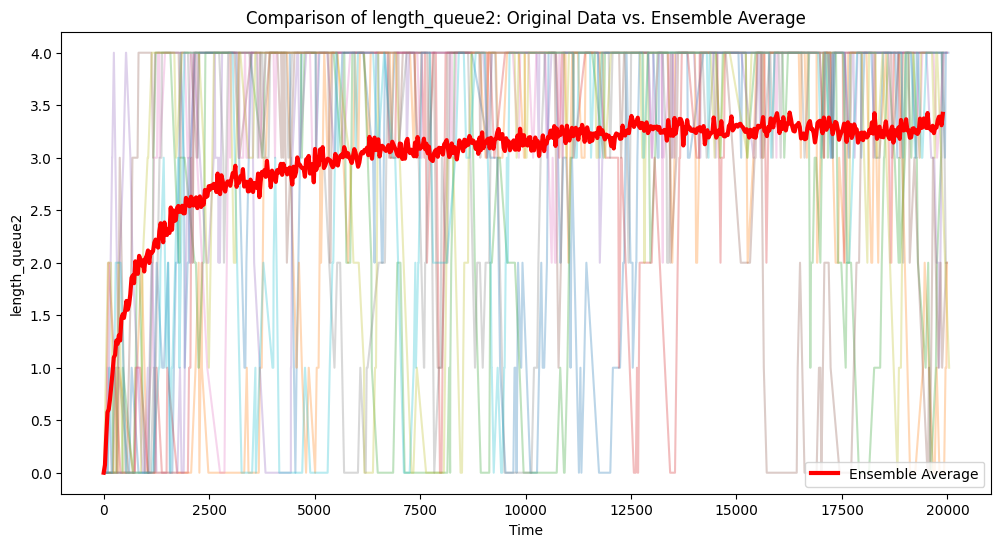

In [44]:
ensemble_data = draw_graph("60.0, 25.0, 59.0, 9223372036854775807,4, \"minutes\", 7.185832891717325", 'length_queue2')


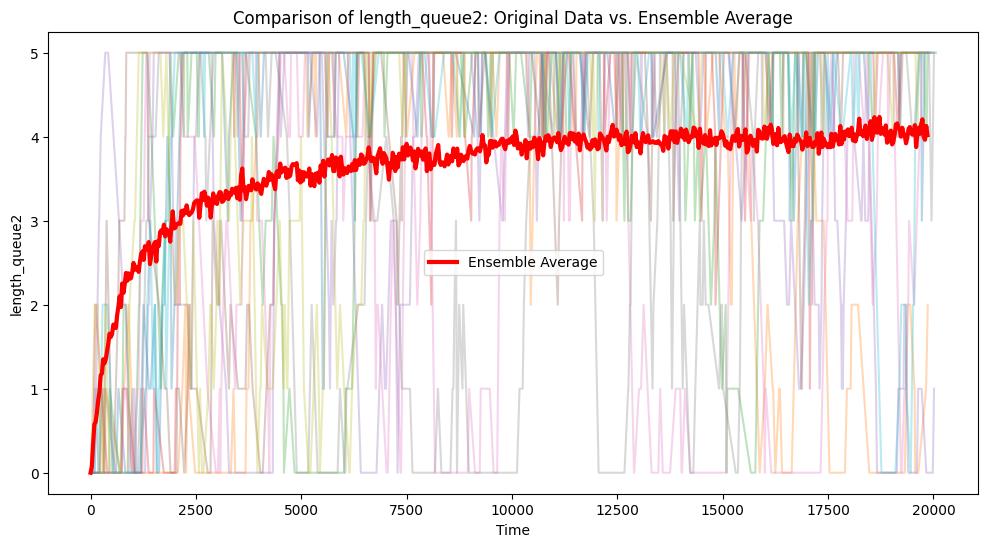

time_bin
0.0        0.000000
30.0       0.074620
60.0       0.342546
90.0       0.576285
120.0      0.603125
             ...   
19740.0    4.207763
19770.0    3.997666
19800.0    3.963644
19830.0    4.128559
19860.0    4.018421
Length: 663, dtype: float64

In [45]:
draw_graph("60.0, 25.0, 59.0, 9223372036854775807,5, \"minutes\", 7.185832891717325", 'length_queue2')


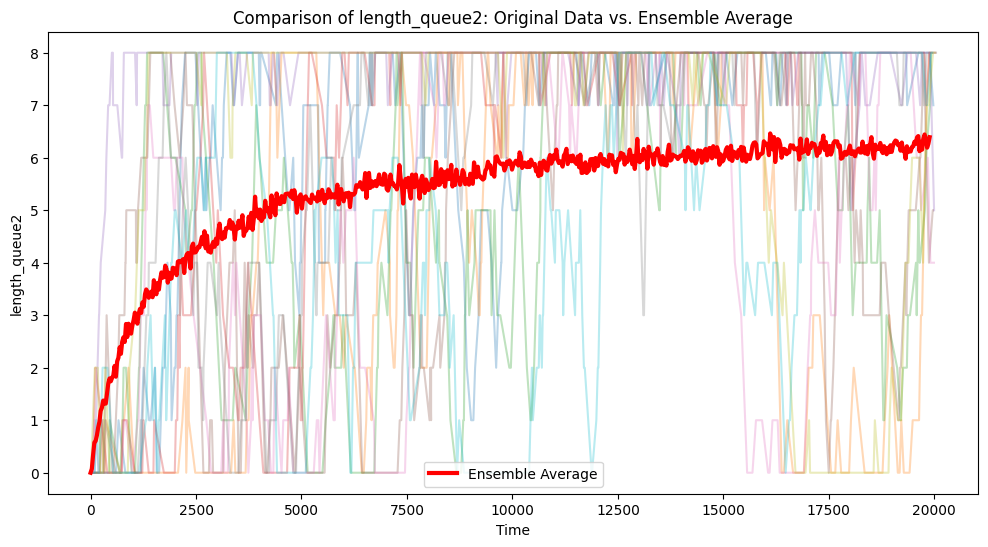

time_bin
0.0        0.000000
30.0       0.074620
60.0       0.342546
90.0       0.576285
120.0      0.603125
             ...   
19770.0    6.443056
19800.0    6.363760
19830.0    6.191140
19860.0    6.265228
19890.0    6.390957
Length: 664, dtype: float64

In [46]:
draw_graph("60.0, 25.0, 59.0, 9223372036854775807,8, \"minutes\", 7.185832891717325", 'length_queue2')


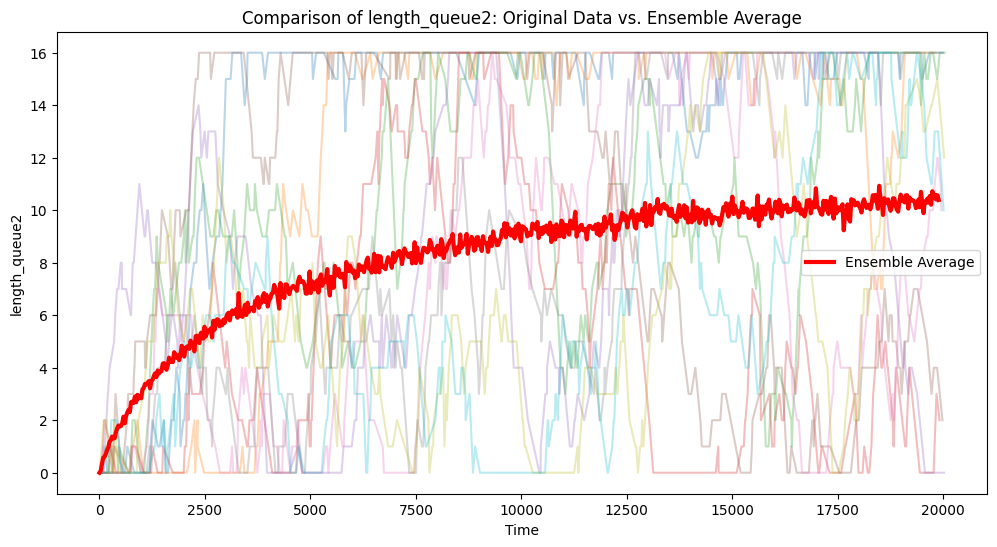

time_bin
0.0         0.000000
30.0        0.074620
60.0        0.342546
90.0        0.576285
120.0       0.603125
             ...    
19770.0    10.460462
19800.0    10.591667
19830.0    10.407149
19860.0    10.572516
19890.0    10.389036
Length: 664, dtype: float64

In [47]:
draw_graph("60.0, 25.0, 59.0, 9223372036854775807,16, \"minutes\", 7.185832891717325", 'length_queue2')


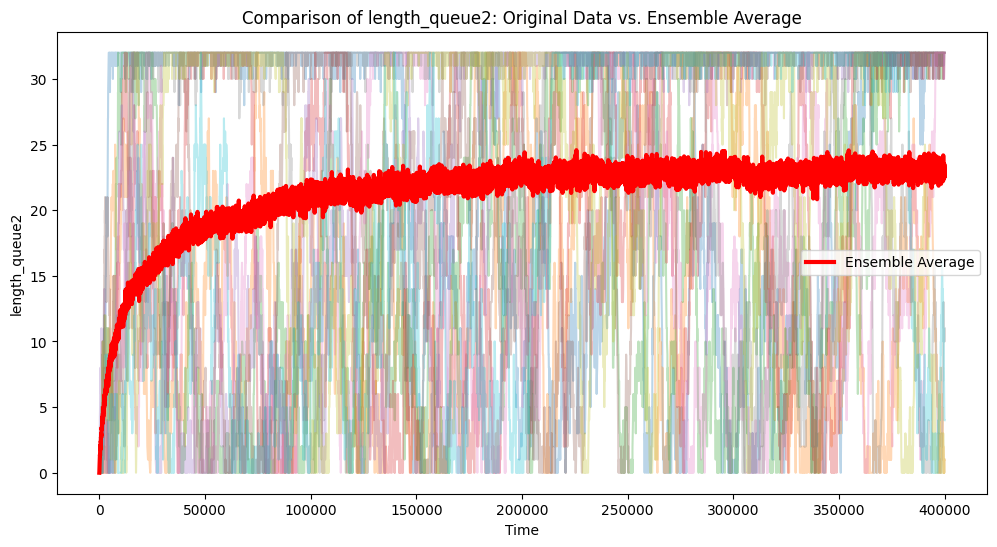

time_bin
0.0          0.000000
30.0         0.074620
60.0         0.342546
90.0         0.576285
120.0        0.603125
              ...    
399810.0    22.490525
399840.0    23.498677
399870.0    23.196078
399900.0    23.152921
399930.0    22.946508
Length: 13332, dtype: float64

In [48]:
draw_graph("60.0, 25.0, 59.0, 9223372036854775807,32, \"minutes\", 7.185832891717325", 'length_queue2')


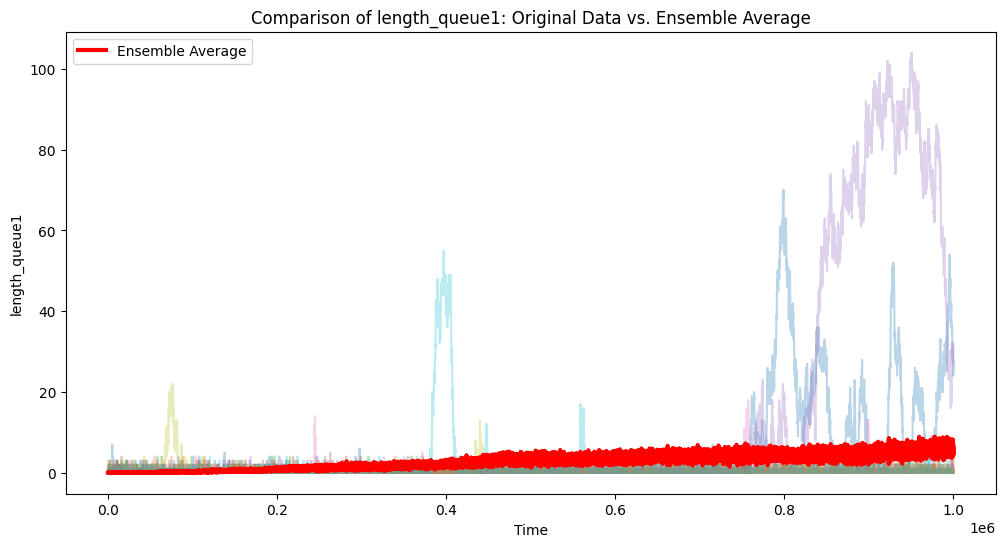

time_bin
0.0         0.022973
30.0        0.104781
60.0        0.113065
90.0        0.129975
120.0       0.110417
              ...   
999780.0    5.817671
999810.0    5.015113
999840.0    5.790905
999870.0    5.771918
999900.0    4.826250
Length: 33331, dtype: float64

In [49]:
draw_graph("60.0, 25.0, 59.0, 9223372036854775807,128, \"minutes\", 7.185832891717325", 'length_queue1')


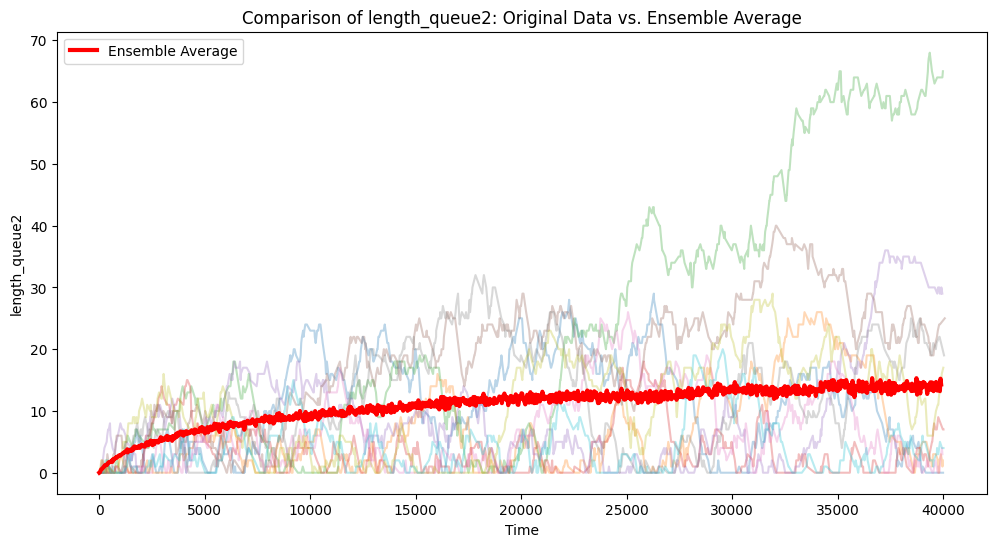

time_bin
0.0         0.000000
30.0        0.071939
60.0        0.340050
90.0        0.557214
120.0       0.598185
             ...    
39780.0    14.158397
39810.0    14.158377
39840.0    13.217851
39870.0    15.223524
39900.0    14.295719
Length: 1331, dtype: float64

In [50]:
draw_graph('60.0, 25.0, 57.0, 9223372036854775807,128, "minutes", 7.185832891717325','length_queue2')


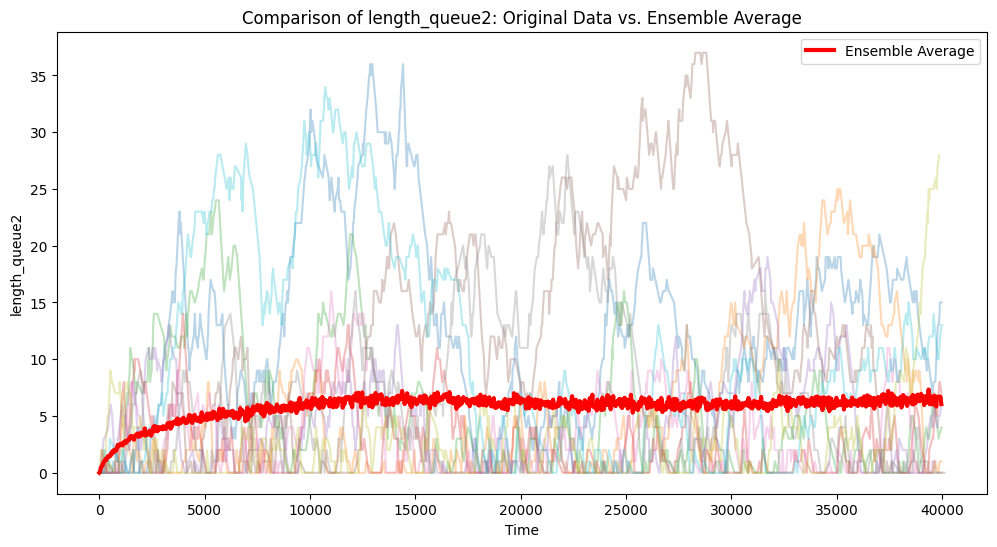

time_bin
0.0        0.000000
30.0       0.066577
60.0       0.319933
90.0       0.525000
120.0      0.575926
             ...   
39840.0    6.651515
39870.0    6.587975
39900.0    6.720591
39930.0    6.672444
39960.0    6.051276
Length: 1333, dtype: float64

In [51]:
draw_graph('60.0, 25.0, 53.0, 9223372036854775807,128, "minutes", 7.185832891717325','length_queue2')


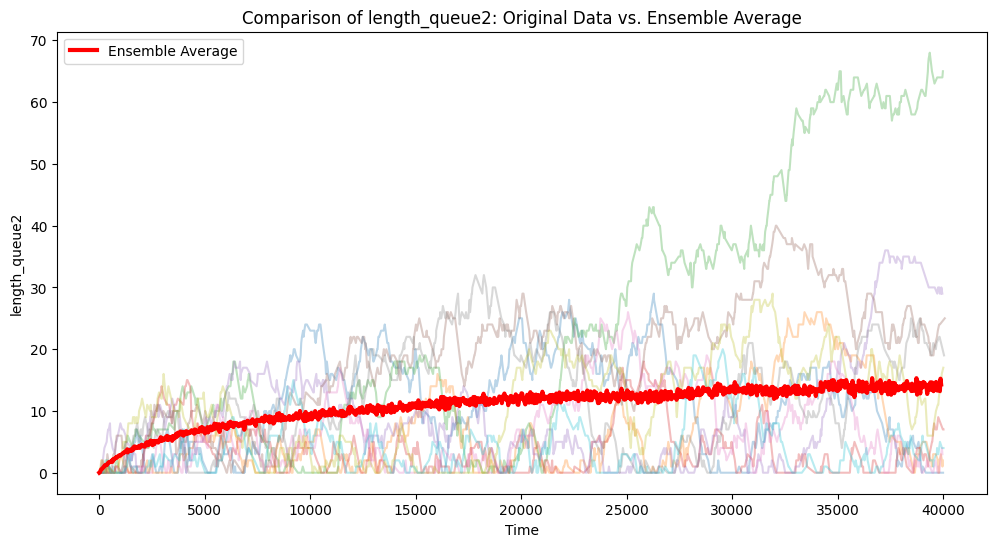

time_bin
0.0         0.000000
30.0        0.071939
60.0        0.340050
90.0        0.557214
120.0       0.598185
             ...    
39780.0    14.158397
39810.0    14.158377
39840.0    13.217851
39870.0    15.223524
39900.0    14.295719
Length: 1331, dtype: float64

In [52]:
draw_graph('60.0, 25.0, 57.0, 9223372036854775807,128, "minutes", 7.185832891717325','length_queue2')


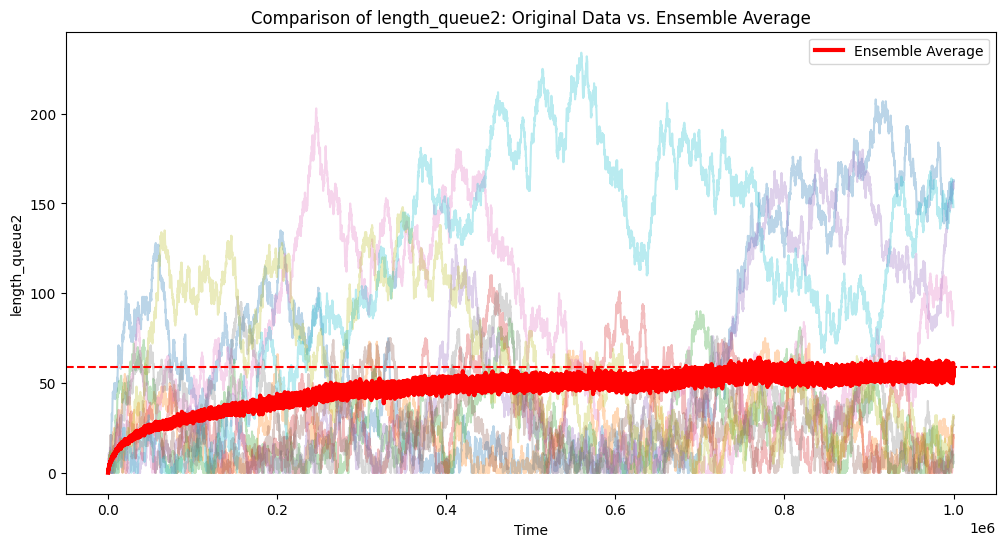

In [55]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,1280, "minutes", 7.185832891717325','length_queue2', guide_line=59)


In [ ]:
draw_graph('60.0, 25.0, 59.0, 9223372036854775807,9223372036854775807, "minutes", 7.185832891717325','length_queue2', guide_line=59)
